In [45]:
from tqdm import tqdm
import matplotlib.pyplot as plt 
import numpy as np
import gif 
import matplotlib as mpl 
import matplotlib.font_manager as fm

In [46]:
@gif.frame
def plot_all_the_particles(particles):
    # assert len(particles) > 0, "Oh noes I ran out of particles to plot. oops."
    x = np.linspace(0,20,20)
    y = np.linspace(0,20,20)

    X,Y = np.array(np.meshgrid(x,y))

    z = Euclidean(X,Y)
    
    #print(f"this is self.v 0 {self.v[0]}, and self.v[1] {self.v[1]}")
    fig = plt.figure(figsize=(8,6))
    plt.imshow(z, extent=[0, 20, 0, 20], origin='lower', cmap='viridis', alpha=0.5)
    plt.colorbar()
    plt.plot(10, 0, marker='*', markersize=20, color="black")
    contours = plt.contour(x, y, z, 10, colors='black', alpha=0.4)
    plt.clabel(contours, inline=True, fontsize=8, fmt="%.0f")

    for p in particles:
        plt.quiver(p.y[0], p.y[1], p.v[0], p.v[1]) 
    return fig



class Particle:
    def __init__(self, pos, velocity, f, w, c1, c2, r1, r2, xlimit, ps):
        """ 
        pos = starting position 
        velocity = starting velocity 
        f = objective function 
        w = weight 
        c1,c2 = cognition weights 
        r1,r2 = acceleration weights 
        xlimit = bounds on searchspace 

        """  
       
        self.x = pos #position
        self.v = velocity #velocity
        self.y = self.x #personal best_positon
        self.py = np.inf #personal best 
        self.objective = f
        #parameters
        self.w = w #inertia weight
        self.c1 = c1 #acceleration constant 
        self.c2 = c2 #accelartation constant
        self.r1 = r1 
        self.r2 = r2 
        self.exitx = 10 
        self.exity = 0
        self.ps = ps
        self.evac = False

        #storage
        self.history = [self.x] #trajectory in search-space

        
    def evaluation(self): 
        """ 
        A function that updates the personal best fitness value and the corresponding position 
        Returns:        fitness
        """

        fitness = self.objective(self.x[0], self.x[1])
        if fitness < self.py:
            self.py = fitness 
            self.y = self.x
        return fitness 
    
    def update(self, gy, vlimit, xlimit):
        """ 
        Update function to update velocity and position and store the trajectory of the particle
        Arguments:          gy = global best fitness position 
                            vlimit = bound to velocity, type = List
                            xlimit = bound to position, type = List
        
        Note: sometimes your x or v values can explode, in these cases, uncomment bound and use a predefined bound
        """
        #original update 
        self.v = self.v + (self.c1 * self.r1 * (self.y - self.x)) + (self.c2 * self.r2 * (gy - self.x)) 
        #inertia update
        #self.v = self.w * self.v + (self.c1 * self.r1 * (self.y - self.x)) + (self.c2 * self.r2 * (gy - self.x)) #velocity update
        if  np.sqrt(self.v[0]**2 + self.v[1]**2) < 1: 
            self.v = self.v/np.sqrt(self.v[0]**2 + self.v[1]**2) #vector normalisation
        #bound velocity 
        # if self.v < vlimit[0]:
        #     self.v = vlimit[0]
        # if self.v > vlimit[1]: 
        #     self.v = vlimit[1]
        self.x = self.x + self.v
        #bound position 
        if self.x[0] < xlimit[0]: 
            self.x[0] = xlimit[0]
        if self.x[1] < xlimit[0]: 
            self.x[1] = xlimit[0]
        if self.x[0] > xlimit[1]:
            self.x[0] = xlimit[1]
        if self.x[1] > xlimit[1]:
            self.x[1] = xlimit[1]

        #story trajectory
        self.history.append(self.x)
        #np.append(self.history, self.x)

    def plot(self):

        x = np.linspace(0,20,20)
        y = np.linspace(0,20,20)

        X,Y = np.array(np.meshgrid(x,y))
        z = self.objective(X,Y)
        
        #print(f"this is self.v 0 {self.v[0]}, and self.v[1] {self.v[1]}")
        plt.figure(figsize=(8,6))
        plt.imshow(z, extent=[0, 20, 0, 20], origin='lower', cmap='viridis', alpha=0.5)
        plt.colorbar()
        plt.plot([self.exitx], [self.exity], marker='*', markersize=20, color="black")
        contours = plt.contour(x, y, z, 10, colors='black', alpha=0.4)
        plt.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
        plt.quiver(self.x[0], self.x[1], self.v[0], self.v[1]) 

    def speed(self):
        return np.sqrt(self.v[0] ** 2 + self.v[1] ** 2 ) 
    
    def evacuate(self): 
        if self.ps == 200: 
            exit_bound = 0.6 
        elif self.ps == 300: 
            exit_bound = 0.85
        elif self.ps == 400: 
            exit_bound = 1.1
        elif self.ps == 500: 
            exit_bound = 1.35 
        elif self.ps == 600: 
            exit_bound = 1.6
        elif self.ps == 10:
            exit_bound = 0.6 


        if self.x[0] > 10 - exit_bound and self.x[0] <10 + exit_bound and self.x[1] < 0.5: 
            self.evac = True


        return self.evac

def test_function(x): 
    """
    Takes input and returns the square root
    Note: this was only to test the initial program 
    """
    return x**2

def optimize(iterations, ps):
    """
    Standard PSO function for function optimization 
    Arguments:          iterations, type int 
                        ps, type int; this is the population size of your swarm 
    plots the trajectory of the swarms"""

    Particles = [Particle(np.random.rand(2, 1) * 20, np.random.randn(2, 1) * 0.1 , Euclidean, 0.2, 0.1, 0.1, 2, 2, [-100,100], ps ) for _ in range(ps)]  #initialize particles
    gy = Particles[np.random.randint(0,ps)].x       #initialize global best position by choosing random position of a particle in swarm 
    gy_fit =  np.inf                               #initialize global best fitness value by infinity, in case of maximization use -gy_fit
    speeds = []
    av_speedit = []
    density = []
    giffie = []
    evacuation_complete = 0
    
    for i in range(iterations):
        for p in Particles:         #iterate over particles
            
            p.evaluation()          #check for best values

            best_fitnesses = [p.py for p in Particles]      #stores the best fitness value that particles have known so far
            best_particle_index = np.argmin(best_fitnesses) #checks which particle has the best fitness of the above fitnesses
            best_particle = Particles[best_particle_index]  #selects the best particle of the swarm in the current iteration

            best_fitnesses = np.asarray(best_fitnesses)
            if np.any(best_fitnesses[:] < gy_fit):         #updates the global best if the best particle of iteration has better values
                gy_fit = np.min(best_fitnesses)
                gy = best_particle.x

            if p.evacuate(): 
                Particles.remove(p)
                if len(Particles) == 0: 
                    print("everyone evacuated")
                    

            else:
                p.update(gy, [-10,10], [0,20])
                speeds.append(p.speed())
                # p.plot()
        if len(Particles) != 0:
            av_speedit.append(sum(speeds)/len(Particles))
            density.append(len(Particles)/40)
            evacuation_complete += 1
            
        else: 
            av_speedit.append(0)
            density.append(0)
        giffie.append(plot_all_the_particles(Particles))
        
    
    plt.plot(density, av_speedit)
    gif.save(giffie, 'evac.gif', duration=100)
    print(evacuation_complete)
    specific_flowrate = ps / (evacuation_complete+1)    
    return evacuation_complete+1       

def Euclidean(X, Y):
    """ 
    Euclidean distance 
    Arguments       dataloc, type == type of position
                    centroid_location, type == type of centroid
                    
    Returns the sqrt of the dotproduct of the data/centroid matrices
    """
    
    return np.sqrt((10 - X)**2 + ( 0 - Y)**2) #returns a list with euclidean distance for each particle? 



/tmp/ipykernel_76338/2798365336.py:178: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  best_fitnesses = np.asarray(best_fitnesses)


everyone evacuated
18
19


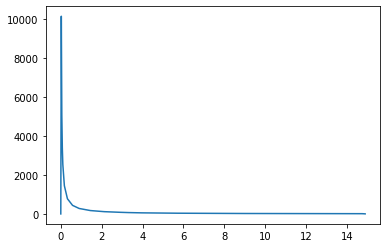

In [29]:
#try out

# for ps in [200, 400, 500, 600]:
#     for i in range(0,5):

sfr = optimize(50,600)
print(sfr)



4.0


In [30]:
#manual calculation of specific flow rates per participant to double check results
a = (200/139 + 2*(200/500) + 200/102 + 200/21) / 5 
print(a)
b = (300/74 + 2*(300/500) + 300/14 + 300/31) / 5 
print(b)
c = (400/18 + 2*(400/17) + 400/58 + 400/48) / 5 
print(c)
d = (500/37 + 2*(500/18) + 500/16 + 500/28) / 5 
print(d)
e = (2 * (600/19) + 2*(600/18) + 600/17) / 5 
print(e)


2.7446885516796646
7.272008967492839
16.902186161821053
23.635242385242385
33.02373581011352


Text(0.5, 0, 'Exit width (m)')

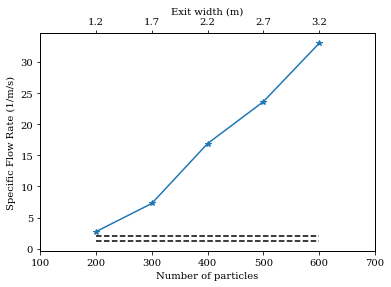

In [58]:
x = [200, 300, 400, 500, 600]
specific_flow_rate = [a,b,c,d,e]
upperbound = [2,2,2,2,2]
lowerbound = [1.25,1.25,1.25,1.25,1.25]
ax = plt.subplot(111)
mpl.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1
ax.plot(x,specific_flow_rate, marker ='*')
ax.plot(x, upperbound,  '--', color="black")
ax.plot(x, lowerbound,  '--', color="black")
ax.set_xlim(100, 700)
ax.set_xlabel("Number of particles")
ax.set_ylabel("Specific Flow Rate (1/m/s)")
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(x)
ax2.set_xticklabels([1.2, 1.7, 2.2, 2.7, 3.2])
ax2.set_xlabel("Exit width (m)")